#Season guesser

Objective: build a deployable proof-of-concept model that can guess the season
if it is given a picture of a landscape.

In [1]:
from pathlib import Path
import fastbook
import os
import sys
notebook_path = Path(os.path.abspath(''))
repo_root = notebook_path.parent.parent
sys.path.append(str(repo_root))
import shared.utils

shared.utils.check_cuda()

CUDA is available via:
NVIDIA GeForce RTX 4090


Make sure you have a .env file with AZURE_SEARCH_KEY in it.

In [2]:
shared.utils.load_env()
data_path = shared.utils.get_data_path() / 'one' / 'seasons'
print(f"{data_path} will be used for data")

Loaded environment variables.
/mnt/c/Users/tflan/git/fastai-coursework/.data/one/seasons will be used for data


Grab images from bing for each category.
Notice I am grouping spring and summer together.
I had no way to tell the difference myself, so I will do 4 searches,
but group spring and summer into the same category.

In [3]:
if not data_path.exists():
    season_searches = {
    'autumn landscape': {'save_to': 'autumn', 'results': 150},
    'winter landscape': {'save_to': 'winter', 'results': 150},
    'spring landscape': {'save_to': 'spring_summer', 'results': 75},
    'summer landscape': {'save_to': 'spring_summer', 'results': 75},
    }
    data_path.mkdir(exist_ok=True, parents=True)
    for search in season_searches:
        save_to = data_path / season_searches[search]['save_to']
        save_to.mkdir(exist_ok=True)
        results = season_searches[search]['results']
        results = fastbook.search_images_bing(
            key=os.environ['AZURE_SEARCH_KEY'],
            term=search,
            max_images=results
        )
        fastbook.download_images(save_to, urls=results.attrgot('contentUrl'))
        corrupted = fastbook.verify_images(fastbook.get_image_files(save_to))
        corrupted.map(Path.unlink)

Training a preliminary model to spot classification errors:

In [4]:
seasons = fastbook.DataBlock(
    blocks=(fastbook.ImageBlock, fastbook.CategoryBlock),
    get_items=fastbook.get_image_files,
    splitter=fastbook.RandomSplitter(valid_pct=0.2, seed=42),
    get_y=fastbook.parent_label,
    item_tfms=fastbook.RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=fastbook.aug_transforms()
)
dataloaders = seasons.dataloaders(str(data_path))
prelim_learner = fastbook.vision_learner(dataloaders, fastbook.resnet34, metrics=fastbook.error_rate)
prelim_learner.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/tflanigan/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|███████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:00<00:00, 112MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.816530,0.893830,0.294872,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.812775,0.501231,0.217949,00:07
1,0.617667,0.208384,0.115385,00:06
2,0.501702,0.161903,0.051282,00:07


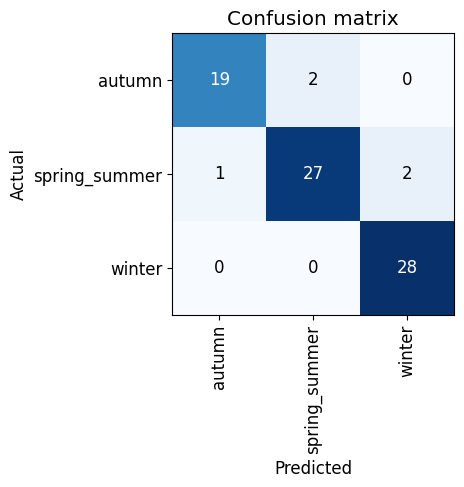

In [8]:
interpretation = fastbook.ClassificationInterpretation.from_learner(prelim_learner)
interpretation.plot_confusion_matrix()

Checking the predictions with the highest losses:

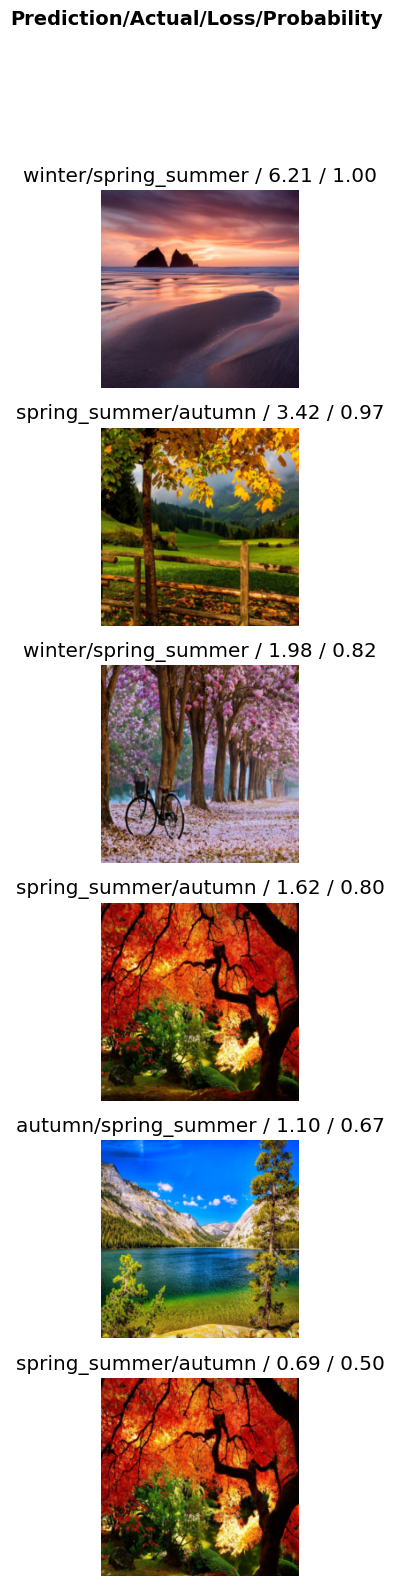

In [10]:
interpretation.plot_top_losses(6, nrows=6)

I deleted some of the ambiguous pictures where I could not tell myself what season it was.
For example, a picture of mostly water with evergreen trees could be any season.
I kept others it was confused by, like cherry blossoms.
I am guessing those look like snow to it, but I will keep stuff like that in for the final training set.

Let's retrain and check again.

epoch,train_loss,valid_loss,error_rate,time
0,1.838296,0.966718,0.333333,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.809250,0.505177,0.205128,00:06
1,0.618505,0.182528,0.051282,00:07
2,0.478711,0.124207,0.064103,00:06


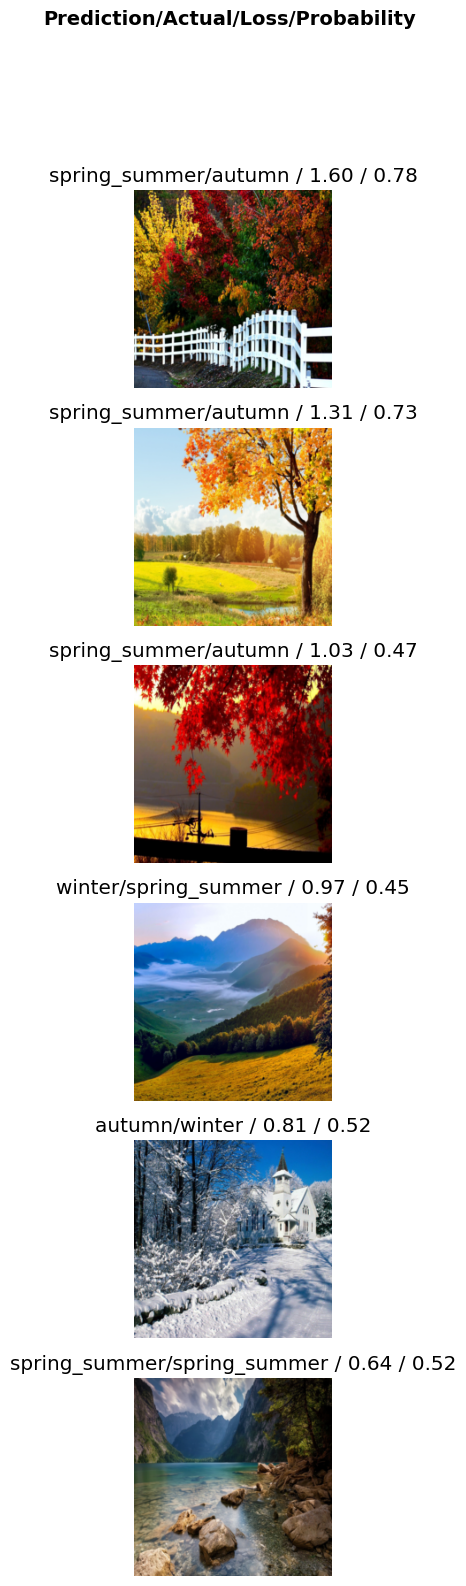

In [5]:
dataloaders = seasons.dataloaders(str(data_path))
prelim_learner = fastbook.vision_learner(dataloaders, fastbook.resnet34, metrics=fastbook.error_rate)
prelim_learner.fine_tune(3)
interpretation = fastbook.ClassificationInterpretation.from_learner(prelim_learner)
interpretation.plot_top_losses(6, nrows=6)

That's looking a lot better now.
Let's train it up on more epochs now.

In [6]:
final_learner = fastbook.vision_learner(dataloaders, fastbook.resnet34, metrics=fastbook.error_rate)
final_learner.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.846685,1.036553,0.423077,00:06


epoch,train_loss,valid_loss,error_rate,time
0,1.021526,0.539543,0.217949,00:07
1,0.720768,0.252999,0.089744,00:06
2,0.571561,0.119095,0.038462,00:06
3,0.452714,0.075326,0.025641,00:06
4,0.368594,0.056668,0.025641,00:06
5,0.315355,0.055301,0.012821,00:06


Let's test out some predictions now.

In [18]:
winter_image = fastbook.Image.open(notebook_path / 'test' / 'winter.jpg')
autumn_image = fastbook.Image.open(notebook_path / 'test' / 'autumn.jpg')
summer_image = fastbook.Image.open(notebook_path / 'test' / 'summer.jpg')
art_image = fastbook.Image.open(notebook_path / 'test' / 'winter-art.jpg')

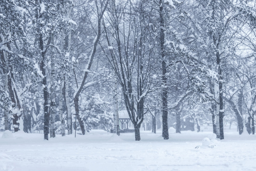

In [20]:
winter_image.to_thumb(256, 256)

In [25]:
print(final_learner.predict(winter_image))

('winter', tensor(2), tensor([1.4713e-04, 1.2064e-04, 9.9973e-01]))


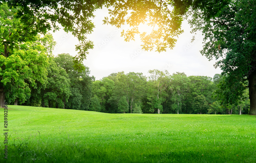

In [21]:
summer_image.to_thumb(256, 256)

In [26]:
print(final_learner.predict(summer_image))

('spring_summer', tensor(1), tensor([6.1795e-07, 1.0000e+00, 1.9209e-08]))


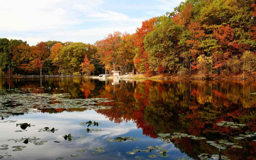

In [22]:
autumn_image.to_thumb(256, 256)

In [27]:
print(final_learner.predict(autumn_image))

('autumn', tensor(0), tensor([0.9974, 0.0015, 0.0011]))


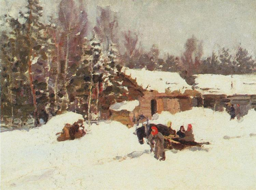

In [23]:
art_image.to_thumb(256, 256)

In [28]:
print(final_learner.predict(art_image))

('winter', tensor(2), tensor([2.7666e-02, 2.0802e-04, 9.7213e-01]))


It seems to still work pretty well for a painting, even though it was trained on photos primarily.

Finally, I'll save the model to a pkl file.

In [7]:
final_learner.export(notebook_path / 'seasons.pkl')